# Imports

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import boto3
import pandas as pd
import glob
from pathlib import Path

# Reading the cleaned data from S3

In [2]:
s3 = boto3.client('s3')
bucket_name = "459-team4-project"
object_key = "clean_data_q2/energy_daily.csv"

obj = s3.get_object(Bucket=bucket_name, Key=object_key)
energy_daily = pd.read_csv(obj['Body'])
energy_daily.head()

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,date
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,2011-12-15
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,2011-12-16
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,2011-12-17
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,2011-12-18
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,2011-12-19


In [3]:
object_key = "clean_data_q2/weather_daily.csv"

obj = s3.get_object(Bucket=bucket_name, Key=object_key)
weather_daily = pd.read_csv(obj['Body'])
weather_daily.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,date
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52,2011-11-11
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53,2011-12-11
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10,2011-12-27
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25,2011-12-02
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99,2011-12-24


In [4]:
object_key = "clean_data_q2/household_info.csv"

obj = s3.get_object(Bucket=bucket_name, Key=object_key)
household_info = pd.read_csv(obj['Body'])
household_info.head()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0


In [5]:
# Check for null values
energy_daily.isnull().sum()

LCLid            0
day              0
energy_median    0
energy_mean      0
energy_max       0
energy_count     0
energy_std       0
energy_sum       0
energy_min       0
date             0
dtype: int64

In [6]:
weather_daily.isnull().sum()

temperatureMax                 0
temperatureMaxTime             0
windBearing                    0
icon                           0
dewPoint                       0
temperatureMinTime             0
cloudCover                     0
windSpeed                      0
pressure                       0
apparentTemperatureMinTime     0
apparentTemperatureHigh        0
precipType                     0
visibility                     0
humidity                       0
apparentTemperatureHighTime    0
apparentTemperatureLow         0
apparentTemperatureMax         0
uvIndex                        0
time                           0
sunsetTime                     0
temperatureLow                 0
temperatureMin                 0
temperatureHigh                0
sunriseTime                    0
temperatureHighTime            0
uvIndexTime                    0
summary                        0
temperatureLowTime             0
apparentTemperatureMin         0
apparentTemperatureMaxTime     0
apparentTe

In [7]:
household_info.isnull().sum()

LCLid            0
stdorToU         0
Acorn            0
Acorn_grouped    0
file             0
dtype: int64

In [8]:
# Check for total rows count
# Around 11k rows were removed as compared to the one on Google Drive
energy_daily.count()

LCLid            3499102
day              3499102
energy_median    3499102
energy_mean      3499102
energy_max       3499102
energy_count     3499102
energy_std       3499102
energy_sum       3499102
energy_min       3499102
date             3499102
dtype: int64

In [9]:
# 1 rows was removed as compared to the one on Google Drive
weather_daily.count()

temperatureMax                 881
temperatureMaxTime             881
windBearing                    881
icon                           881
dewPoint                       881
temperatureMinTime             881
cloudCover                     881
windSpeed                      881
pressure                       881
apparentTemperatureMinTime     881
apparentTemperatureHigh        881
precipType                     881
visibility                     881
humidity                       881
apparentTemperatureHighTime    881
apparentTemperatureLow         881
apparentTemperatureMax         881
uvIndex                        881
time                           881
sunsetTime                     881
temperatureLow                 881
temperatureMin                 881
temperatureHigh                881
sunriseTime                    881
temperatureHighTime            881
uvIndexTime                    881
summary                        881
temperatureLowTime             881
apparentTemperatureM

In [10]:
# Number of rows same as the one on Google Drive
household_info.count()

LCLid            5566
stdorToU         5566
Acorn            5566
Acorn_grouped    5566
file             5566
dtype: int64

# Prepare data for regression model

In [1]:
# Merge datasets on the 'date' column
data = pd.merge(energy_daily, weather_daily, on='date', how='inner')

NameError: name 'pd' is not defined

In [ ]:
# Drop target variable from features
X = data.drop(columns=['energy_sum'])
y = data['energy_sum']

In [ ]:
# Select only numeric columns for scaling
X_numeric = X.select_dtypes(include=['number'])

In [14]:
# Normalize all feature columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

In [15]:
# Use X_scaled directly, no PCA
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train the XGBoost Regressor

In [16]:
xg_model = xgb.XGBRegressor(random_state=42)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# Predict and evaluate results

In [17]:
y_pred_xg = xg_model.predict(X_test)

mae_xg = mean_absolute_error(y_test, y_pred_xg)
mse_xg = mean_squared_error(y_test, y_pred_xg)
r2_xg = r2_score(y_test, y_pred_xg)

print(f"Mean Absolute Error (MAE): {mae_xg}")
print(f"Mean Squared Error (MSE): {mse_xg}")
print(f"R-squared (R²): {r2_xg}")

Mean Absolute Error (MAE): 0.09833437844481606
Mean Squared Error (MSE): 0.8348102490315831
R-squared (R²): 0.9898905539719939


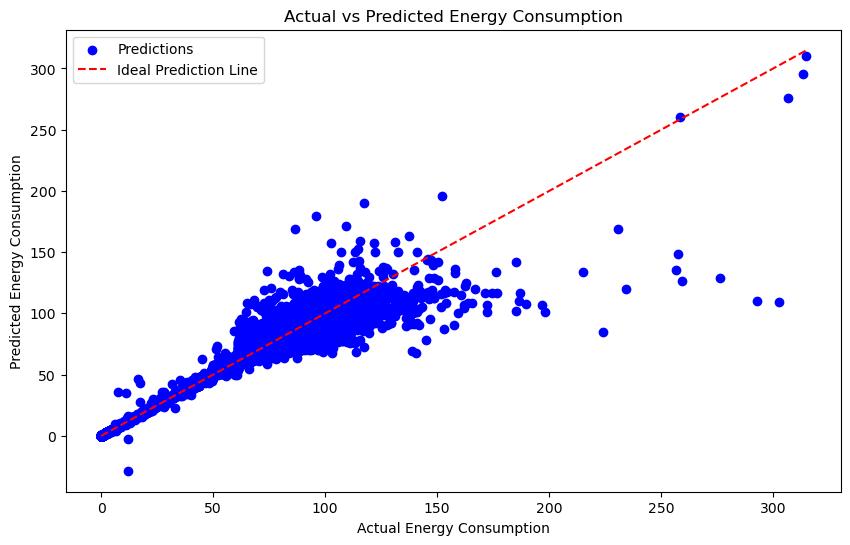

In [18]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_xg, color='blue', label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Prediction Line')
plt.xlabel('Actual Energy Consumption')
plt.ylabel('Predicted Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()

In [19]:
# Export the DataFrame to a CSV file locally
from botocore.exceptions import NoCredentialsError
output_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_xg})
output_df.to_csv('output_q2.csv', index=False)

print("Energy Prediction exported to 'output_q2.csv'")

# Upload the file to S3
s3_bucket_name = '459-team4-project'
s3_folder_path = 'notebook_output_q2/output_q2.csv'

# Initialize a session using Amazon S3
s3_client = boto3.client('s3')

try:
    # Upload the file
    s3_client.upload_file('output_q2.csv', s3_bucket_name, s3_folder_path)
    print(f"File successfully uploaded to s3://{s3_bucket_name}/{s3_folder_path}")
except NoCredentialsError:
    print("Credentials not available.")
except Exception as e:
    print(f"Error uploading file: {e}")